In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

print(f"Torch Version: {torch.__version__}")

Torch Version: 2.0.1+cu118


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cuda


In [3]:
# Data Generation

weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Train/Test Split

splitRatio = 0.8
trainSplit = int(splitRatio * len(X))

XTrain, yTrain = X[:trainSplit], y[:trainSplit]
XTest, yTest = X[trainSplit:], y[trainSplit:]

len(XTrain), len(yTrain), len(XTest), len(yTest)

(40, 40, 10, 10)

In [7]:
# Plot Function

def plotPredictions(dataTrain=XTrain,
                    labelsTrain=yTrain,
                    dataTest=XTest,
                    labelsTest=yTest,
                    predictions=None):

  plt.figure(figsize=(12, 8))
  plt.scatter(dataTrain, labelsTrain, c="b", s=4, label="Training Data")
  plt.scatter(dataTest, labelsTest, c="g", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(dataTest, predictions, c="r", s=4, label="Prediction")

  plt.legend(prop={"size": 14})

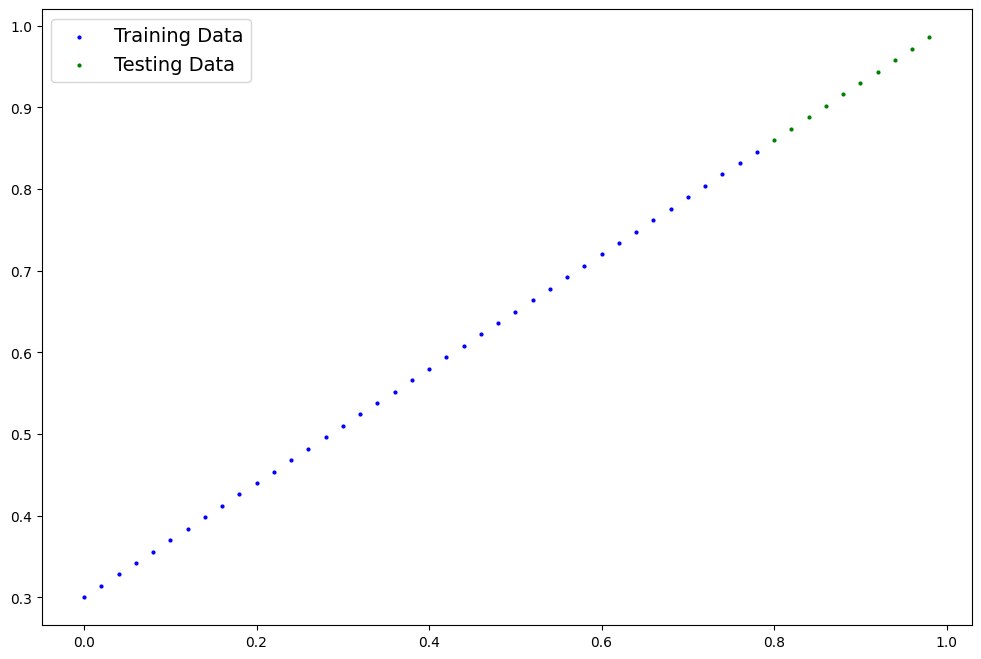

In [8]:
plotPredictions();

In [15]:
# Building Model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linearLayer = nn.Linear(in_features=1,
                                 out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linearLayer(x)

torch.manual_seed(42)
model0 = LinearRegressionModel()
model0, model0.state_dict()

(LinearRegressionModel(
   (linearLayer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linearLayer.weight', tensor([[0.7645]])),
              ('linearLayer.bias', tensor([0.8300]))]))

In [16]:
# Checking model device

next(model0.parameters()).device

device(type='cpu')

In [17]:
# Changind device
model0.to(device)

next(model0.parameters()).device

device(type='cuda', index=0)

In [18]:
lossFn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.01)

In [19]:
# Creating a training loop

torch.manual_seed(42)
epochs = 100

# Putting data to GPU
XTrain = XTrain.to(device)
yTrain = yTrain.to(device)
XTest = XTest.to(device)
yTest = yTest.to(device)

for epoch in range(epochs):
  model0.train()
  yPred = model0(XTrain)
  loss = lossFn(yPred, yTrain)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model0.eval()

  with torch.inference_mode():
    testPred = model0(XTest)
    testLoss = lossFn(testPred, yTest)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {testLoss}")

Epoch: 0 | Train Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Train Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Train Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Train Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Train Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Train Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Train Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Train Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Train Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Train Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703


In [20]:
model0.state_dict()

OrderedDict([('linearLayer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linearLayer.bias', tensor([0.3130], device='cuda:0'))])

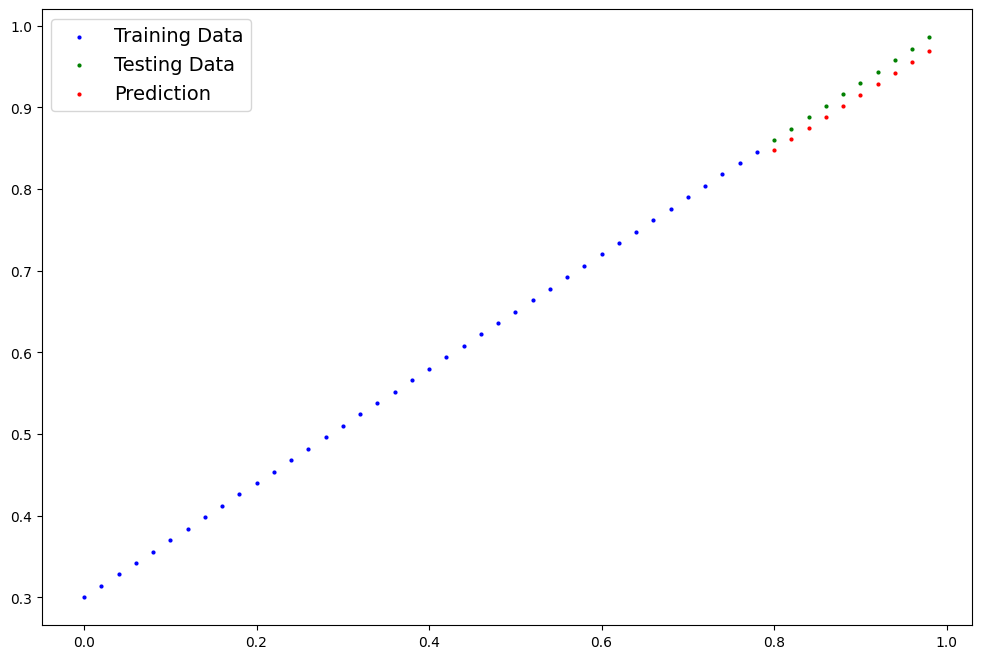

In [25]:
# Predictions

model0.eval()
yPred = model0(XTest)

plotPredictions(predictions=yPred.detach().cpu());

In [26]:
# Saving the model

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "LinearRegressionModel1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

Saving to models/LinearRegressionModel1.pth


In [27]:
# Loading a model

model1 = LinearRegressionModel()
model1.load_state_dict(torch.load(MODEL_SAVE_PATH))

model1.to(device)
model1.state_dict()

OrderedDict([('linearLayer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linearLayer.bias', tensor([0.3130], device='cuda:0'))])